<a href="https://colab.research.google.com/github/bhavyaKumawat/tensorflow-datasets/blob/main/Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Sunspots](https://www.kaggle.com/robervalt/sunspots)

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
# Mounting Google Drive locally
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# make a directory 
! mkdir /root/.kaggle
# copy kaggle API Token from Google Drive
! cp 'drive/MyDrive/Colab Notebooks/kaggle.json' '/root/.kaggle/kaggle.json'

In [ ]:
# Download dataset files
! kaggle datasets download robervalt/sunspots

  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 37.4MB/s]


In [ ]:
# Extract all members from the sunspots.zip to cwd
with ZipFile('sunspots.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Read Sunspots.csv file into DataFrame
sunspots = pd.read_csv("Sunspots.csv",                    
                       usecols= ["Date",	"Monthly Mean Total Sunspot Number"],
                       parse_dates=[0],
                       dayfirst=True)
sunspots.columns = ['Date', 'Total']
# Let's display the first 10 rows
sunspots.head(10)

,Date,Total
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5
9,1749-10-31,125.8


In [ ]:
# More information 
sunspots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3265 non-null   datetime64[ns]
 1   Total   3265 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.1 KB


In [ ]:
# function to plot time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Date")
    plt.ylabel("Monthly Mean Total Sunspot Number")

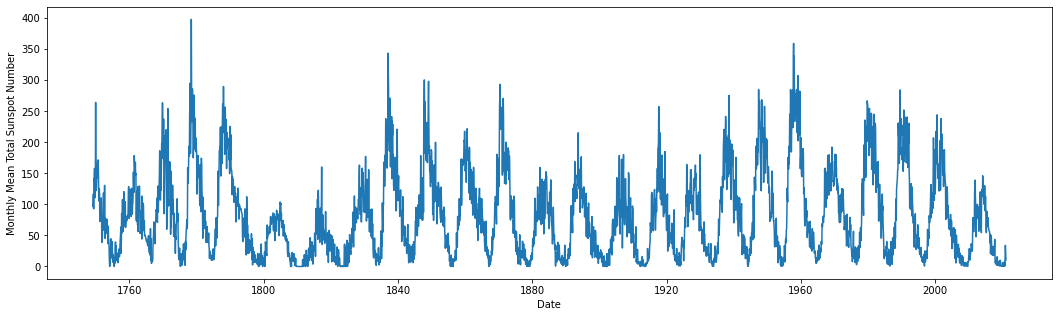

In [ ]:
# plot dataset
plt.figure(figsize=(18, 5))
plot_series(sunspots['Date'], sunspots['Total'])

In [ ]:
# Fixed Partitioning
split = 2800
series = np.array(sunspots["Total"])
train_dates = np.array(sunspots[:split]["Date"])
train_sunspots = np.array(sunspots[:split]["Total"])
valid_dates = np.array(sunspots[split:]["Date"])
valid_sunspots = np.array(sunspots[split:]["Total"])

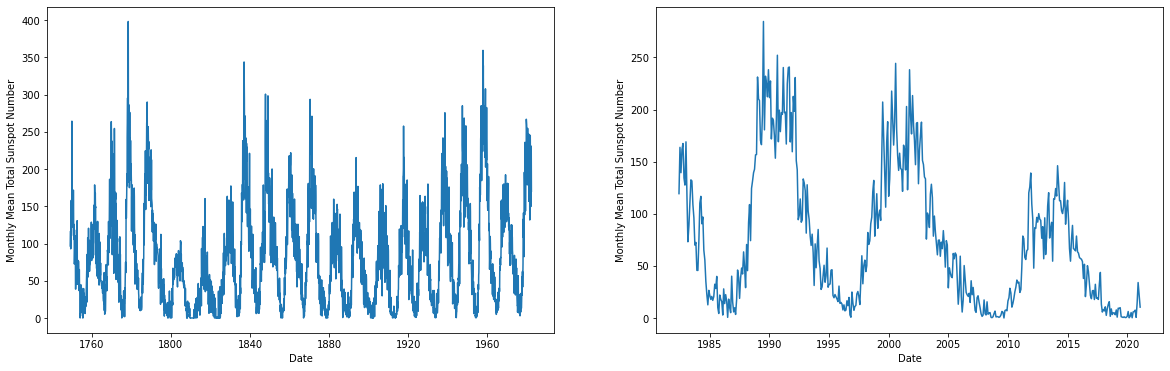

In [ ]:
# plot training dataset and validation dataset
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_series(train_dates, train_sunspots)
plt.subplot(1, 2, 2)
plot_series(valid_dates, valid_sunspots)
plt.show()

### Naive Forecasting 

In [ ]:
# We Take the last value and assume that the next value will be the same one, this is called naive forecasting 
naive_forecast = sunspots['Total'][split - 1:-1]

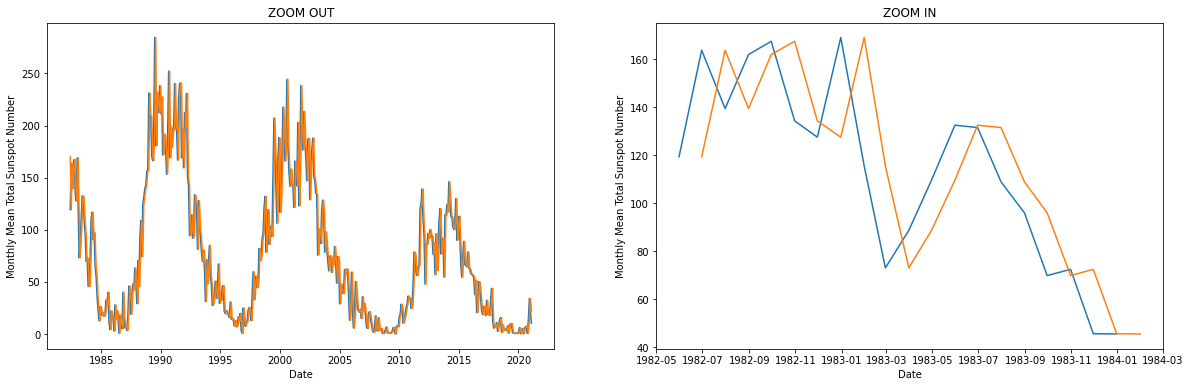

In [ ]:
# Plot predicted time series vs original time series
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.gca().set_title('ZOOM OUT')
plot_series(valid_dates, valid_sunspots) # Original time series
plot_series(valid_dates, naive_forecast) # Predicted time series

# Let's zoom into the plot
plt.subplot(1, 2, 2)
plt.gca().set_title('ZOOM IN')
plot_series(valid_dates, valid_sunspots, end = 20) # Original time series
plot_series(valid_dates, naive_forecast, start=1, end = 21) # Predicted time series

plt.show()

In [ ]:
# evaluating performance using MAE (mean absolute error)
keras.metrics.mean_absolute_error(valid_sunspots, naive_forecast).numpy()

16.87978494623656

### Moving average Forecasting

Average of the values over a fixed period called an averaging window

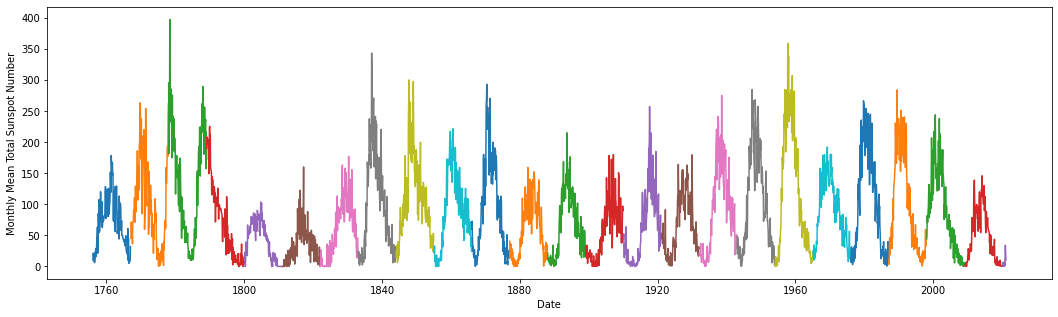

In [ ]:
# Finding seasonality period
plt.figure(figsize=(18, 5))
seasonality_period = 132 # 132 months i.e. 11-year cycle
for x in range(27):
  first_min = 84 
  plot_series(sunspots['Date'], sunspots['Total'], start = first_min+ (seasonality_period*x), end = first_min+(seasonality_period*(x+1)))

# Since the seasonality period is 132 months, we will subtract the value at time t-132 from the value at time t.

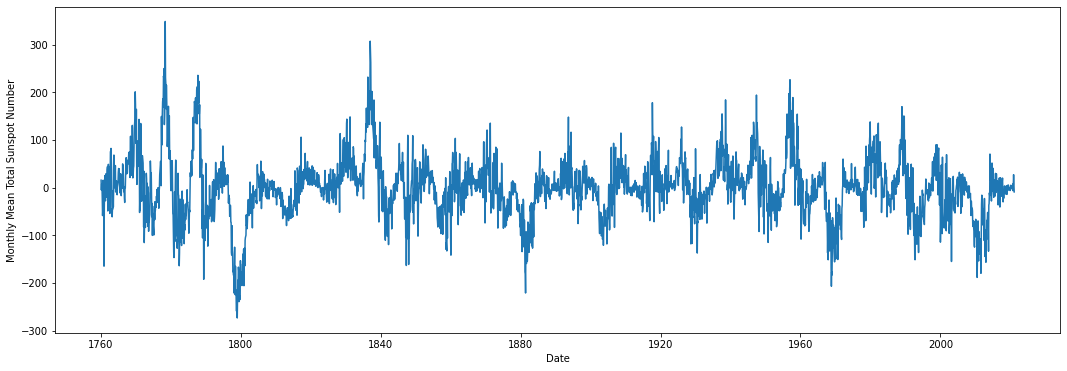

In [ ]:
# Differencing - Technique to remove trend and seasonality from the time series 

diff_series = np.array(sunspots['Total'][seasonality_period:])  - np.array(sunspots['Total'][:-seasonality_period])
diff_date = sunspots['Date'][seasonality_period:]

plt.figure(figsize=(18, 6))
plot_series(diff_date, diff_series)

In [ ]:
# Forecasts the average over a fixed period. If window_size=1, then this is equivalent to naive forecast 
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

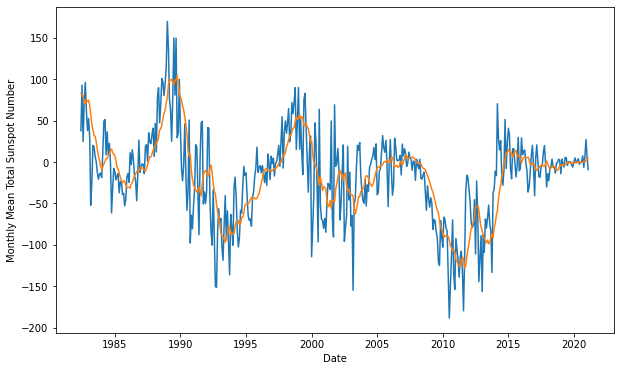

In [ ]:
# Forecast the differenced time series using moving average

window_size = 10
moving_average = moving_average_forecast(diff_series, window_size)[split - seasonality_period - window_size:]

plt.figure(figsize=(10, 6))
plot_series( valid_dates, diff_series[split - seasonality_period:])
plot_series(valid_dates, moving_average)

# But these are just forecasts for the differenced time series, not the original time series.

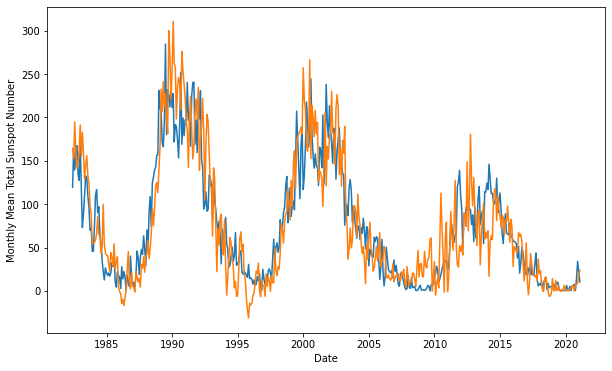

In [ ]:
# To get the final forecasts for the original time series, we just need to add back the value at time t-132

moving_avg_plus_past = np.array(sunspots["Total"][split-seasonality_period: -seasonality_period]) + moving_average

plt.figure(figsize=(10, 6))
plot_series(valid_dates, valid_sunspots)
plot_series(valid_dates, moving_avg_plus_past)

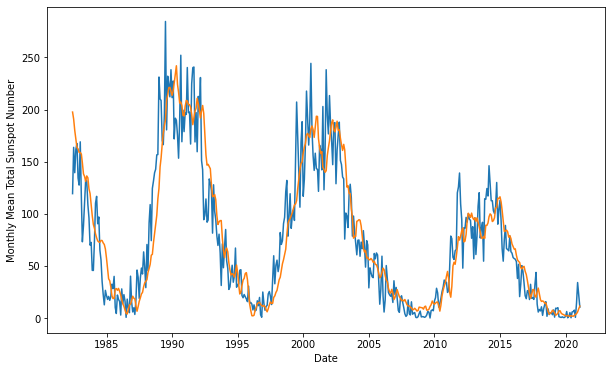

In [ ]:
# Removing the noise coming from the past values that we added back into our forecasts. Let's use a moving averaging on past values:

pastValueWindowSize = 7
moving_avg_forecast = moving_average_forecast(sunspots["Total"][split-pastValueWindowSize-seasonality_period : -seasonality_period], 
                                                      pastValueWindowSize) + moving_average

plt.figure(figsize=(10, 6))
plot_series(valid_dates, valid_sunspots)
plot_series(valid_dates, moving_avg_forecast)

In [ ]:
# evaluating performance using MAE (mean absolute error)
keras.metrics.mean_absolute_error(valid_sunspots, moving_avg_forecast).numpy()

19.425293394777263

### Using Deep Neural Networks for forecasting

In [ ]:
def windowed_dataset( series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Using Windowing on Dataset
    dataset = dataset.window(window_size + 1, shift= 1, drop_remainder= True)
    # Flatten the data into chunks of size (window_size+1)
    dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
    # Shuffle helps us to rearrange the data so as not to accidentally introduce a sequence bias
    dataset = dataset.shuffle(shuffle_buffer)
    # split the data into features and labels
    dataset = dataset.map(lambda window : (window[:-1], window[-1] ))
    # batching the data
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
        

In [ ]:
# Hyperparameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# Using Windowed Dataset
dataset = windowed_dataset(train_sunspots ,window_size, batch_size, shuffle_buffer_size)

# build the model
DNN = keras.Sequential([
                          keras.layers.Dense(20, input_shape= [window_size], activation="relu"),
                          keras.layers.Dense(10, activation="relu"),
                          keras.layers.Dense(1)
])

# tweak the learning rate using learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**( epoch/20 )
)

# compile the model
optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9)
DNN.compile(loss = "mse", optimizer = optimizer )
history = DNN.fit(dataset, epochs = 100, callbacks= [lr_schedule], verbose = 0)

Text(0, 0.5, 'Loss')

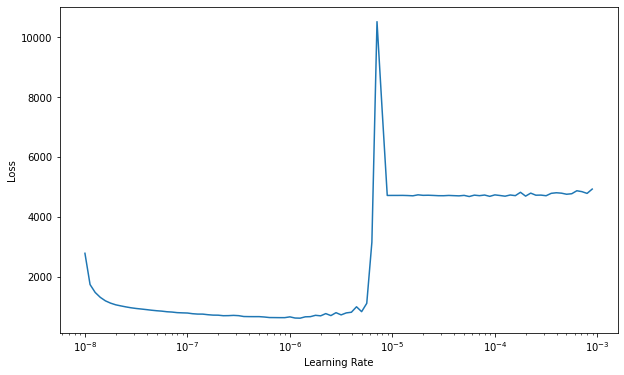

In [ ]:
# plot the loss per epoch against the learning rate per epoch

plt.figure(figsize=(10, 6))
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

In [ ]:
# pick the lowest point of the curve where it's relatively stable and set that to be the learning rate and retrain for a bit longer without lr_schedule

DNN = keras.Sequential([
                          keras.layers.Dense(20, input_shape= [window_size], activation="relu"),
                          keras.layers.Dense(10, activation="relu"),
                          keras.layers.Dense(1)
])

# compile the model
optimizer = keras.optimizers.SGD(learning_rate = 2e-7, momentum = 0.9)
DNN.compile(loss = "mse", optimizer = optimizer )
history = DNN.fit(dataset, epochs = 100, verbose = 0) 

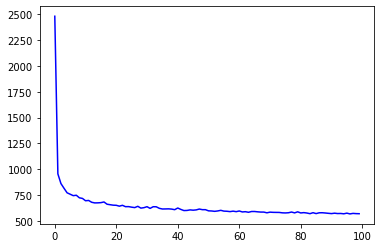

In [ ]:
# Plotting Training Loss
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label = "Training Loss")
plt.show()

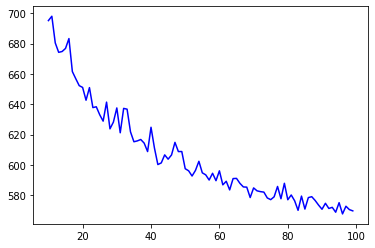

In [ ]:
# its somewhat skewed because the earlier losses are so high. So we'll crop them off and plot the loss for epochs after 10
loss = history.history["loss"]
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, "b", label = "Training Loss")
plt.show()

In [ ]:
# function to make prediction
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


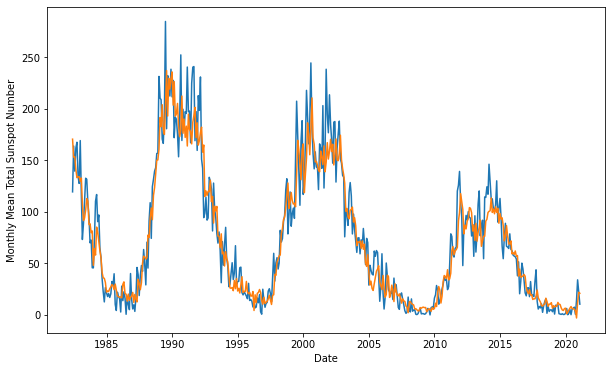

In [ ]:
# Predictions

dnn_forecast = model_forecast(DNN, series, window_size)
dnn_forecast = dnn_forecast[split - window_size:-1,  0]

plt.figure(figsize=(10, 6))
plot_series(valid_dates, valid_sunspots)
plot_series(valid_dates, dnn_forecast)

In [ ]:
# evaluating performance using MAE (mean absolute error)
tf.keras.metrics.mean_absolute_error(valid_sunspots, dnn_forecast).numpy()

15.278016

###Using RNNs  for forecasting

In [ ]:
# input shape when using RNNs is three-dimensional [ batch size, time steps, dims]

# build the model
RNN = keras.Sequential([    
    # Batch processing
    # input shape -> [None], we're saying that the model can take sequences of any length
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    
    # timesteps is set to None, which means that the RNN can handle sequences of any length
    # dims is 1 because we're using a univariate time series
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),

    # scaling up the outputs by 100 can help with training
    keras.layers.Lambda(lambda x : x * 100.0)
    
])

In [ ]:
#  tweak the learning rate using learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**( epoch/20 )
)

# compile the model
optimizer = keras.optimizers.SGD(learning_rate = 5e-5, momentum = 0.9)
RNN.compile(loss = "mse" , optimizer = optimizer, metrics= ["mae"])
history = RNN.fit(dataset, epochs = 100, callbacks= [lr_schedule], verbose =  0)


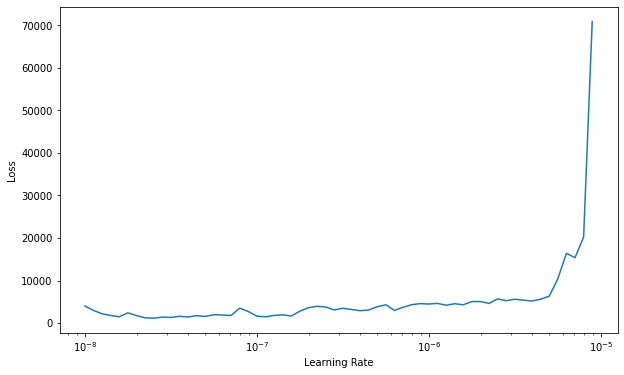

In [ ]:
# plot the loss per epoch against the learning rate per epoch

plt.figure(figsize=(10, 6))
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

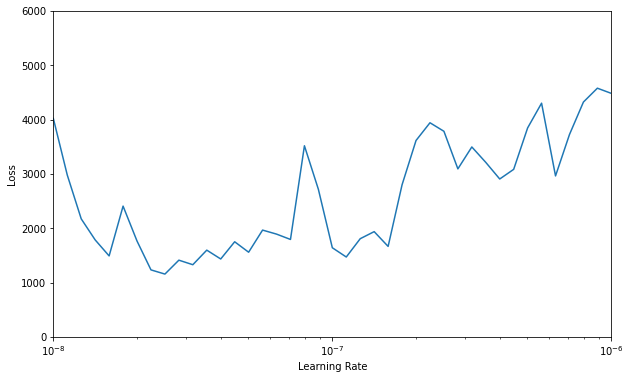

In [ ]:
# take a closer look
plt.figure(figsize=(10, 6))
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
       # [xmin, xmax, ymin, ymax]
plt.axis([1e-8, 1e-6, 0, 6000])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

In [ ]:
# pick the lowest point of the curve where it's relatively stable and set that to be the learning rate and retrain for a bit longer without lr_schedule

# build the model
RNN = keras.Sequential([    
    # Batch processing
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),

    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
    
    # scaling up the outputs by 100 
    keras.layers.Lambda(lambda x : x * 100.0)
    
])

# compile the model
optimizer = keras.optimizers.SGD(learning_rate = 2e-8, momentum = 0.9)
RNN.compile(loss = "mse", optimizer = optimizer , metrics= ["mae"])
history = RNN.fit(dataset, epochs = 100, verbose = 0) 

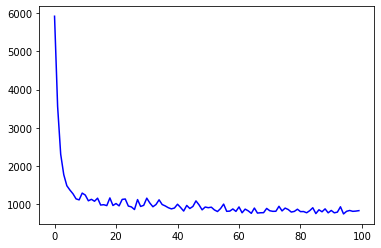

In [ ]:
# Plotting Training Loss
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label = "Training Loss")
plt.show()

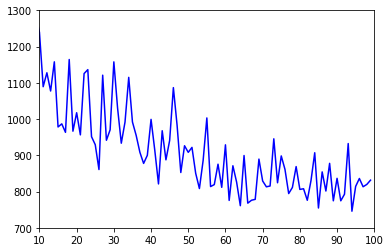

In [ ]:
# take a closer look

loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label = "Training Loss")
plt.axis([10, 100, 700, 1300])
plt.show()

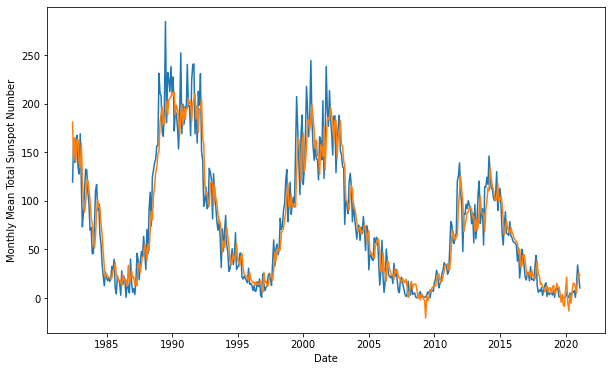

In [ ]:
# Make Predictions

rnn_forecast = model_forecast(RNN, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1,  0]

plt.figure(figsize=(10, 6))
plot_series(valid_dates, valid_sunspots)
plot_series(valid_dates, rnn_forecast)

In [ ]:
# evaluating performance using MAE (mean absolute error)
tf.keras.metrics.mean_absolute_error(valid_sunspots, rnn_forecast).numpy()

16.00348

### Using LSTMs for forecasting

In [ ]:
# hyperparameter
window_size = 60
batch_size = 64

LSTM = keras.Sequential([
    # input shape -> [None], we're saying that the model can take sequences of any length
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1),
    # scaling up the outputs by 100 can help with training
    keras.layers.Lambda(lambda x : x * 100.0)
    
])

#  tweak the learning rate using learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10**( epoch/20 )
)

# compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9)
LSTM.compile(loss = "mse" , optimizer = optimizer)
history = LSTM.fit(dataset, epochs = 50, callbacks= [lr_schedule], verbose = 0)

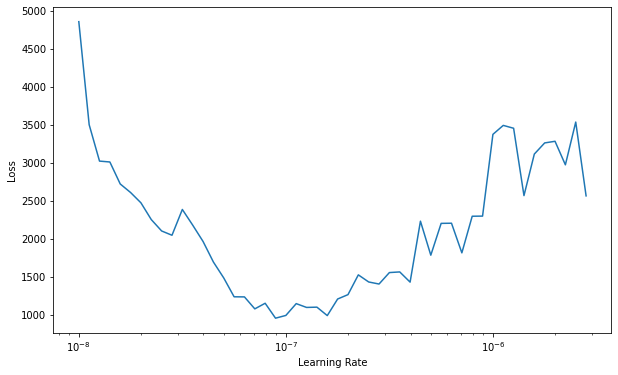

In [ ]:
# plot the loss per epoch against the learning rate per epoch

plt.figure(figsize=(10, 6))
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

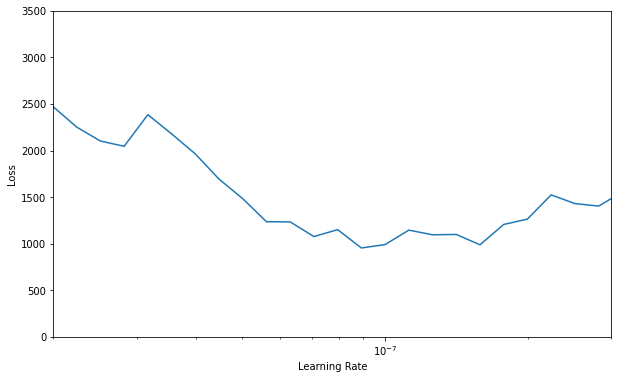

In [ ]:
# take a closer look
plt.figure(figsize=(10, 6))
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["loss"])
       # [xmin, xmax, ymin, ymax]
plt.axis([2e-8, 3e-7, 0, 3500])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

In [ ]:
# pick the lowest point of the curve where it's relatively stable and set that to be the learning rate and retrain for a bit longer without lr_schedule

LSTM = keras.Sequential([
    # input shape -> [None], we're saying that the model can take sequences of any length
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1),
    # scaling up the outputs by 100 can help with training
    keras.layers.Lambda(lambda x : x * 100.0)
    
])

# compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate = 9e-8, momentum = 0.9)
LSTM.compile(loss = "mse" , optimizer = optimizer)
history = LSTM.fit(dataset, epochs = 200, verbose = 0)

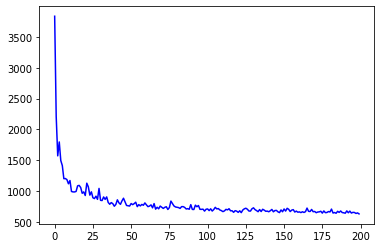

In [ ]:
# Plotting Training Loss
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label = "Training Loss")
plt.show()

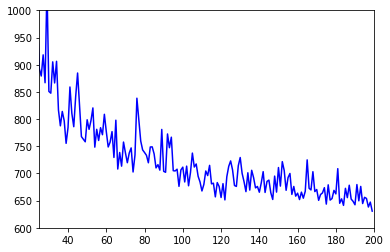

In [ ]:
# take a closer look

loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label = "Training Loss")
plt.axis([25, 200, 600, 1000])
plt.show()

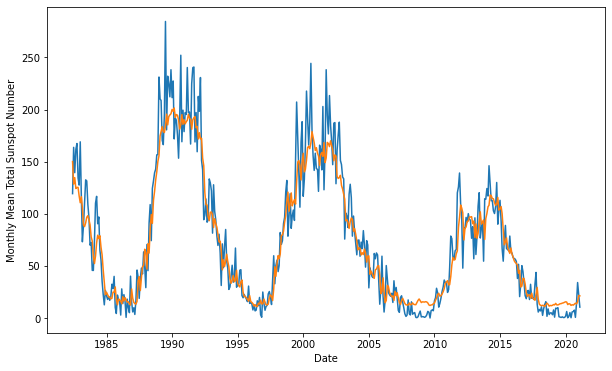

In [ ]:
# Make Predictions
lstm_forecast = model_forecast(LSTM, series[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(valid_dates, valid_sunspots)
plot_series(valid_dates, lstm_forecast)

In [ ]:
# evaluating performance using MAE (mean absolute error)
tf.keras.metrics.mean_absolute_error(valid_sunspots, lstm_forecast).numpy()

15.556185